In [1]:
%load_ext autoreload
import pandas as pd
from clustering_and_prim_tools import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data2day      = 30
year          = 2030
ini_year      = 2007

nameofthisround = 'sept2016_4'


In [4]:
countrycode="SEN"

In [6]:
forprim_bau = pd.read_csv(countrycode+"_bau.csv")

In [7]:
forprim_bau["scenar_id"] = forprim_bau.scenar.astype(str)+forprim_bau.ssp.astype(str)

In [8]:
forprim_bau.set_index("scenar_id",inplace=True)

In [9]:
def turn_pc(forprim,var):
    newcol = var+"pc"
    forprim[newcol] = forprim[var]/forprim["tot_pop"]
    return forprim

In [10]:
forprim_bau.columns

Index(['countryname', 'scenar', 'ssp', 'ccint', 'country', 'year', 'GDP',
       'avincome', 'incbott10', 'incbott20', 'inc2040', 'incbott40',
       'quintilecum1', 'quintilecum2', 'quintilepc1', 'quintilepc2',
       'belowpovline', 'below2', 'below4', 'below6', 'below8', 'below10',
       'gini', 'tot_pop', 'gappovline', 'gap2', 'gap4', 'gap6', 'gap8',
       'gap10', 'childrenag', 'childrenonag', 'peopleag', 'peoplenonag',
       'avincomeag', 'avincomenonag', 'shareag', 'sharemanu', 'shareemp',
       'grserv', 'grag', 'grmanu', 'skillpserv', 'skillpag', 'skillpmanu', 'p',
       'b', 'voice', 'prod_gr_ag', 'prod_gr_serv', 'prod_gr_manu', 'issp5'],
      dtype='object')

In [11]:
forprim_bau = forprim_bau.drop("ccint",axis=1).drop_duplicates()

In [12]:
forprim_bau = turn_pc(forprim_bau,"belowpovline")
forprim_bau = turn_pc(forprim_bau,"below2")
forprim_bau = turn_pc(forprim_bau,"below4")

In [13]:
ini_data = pd.read_csv("ini_data_info_may14.csv")
ini = ini_data.loc[ini_data.countrycode==countrycode,:]

In [14]:
forprim_bau["shprosp"] = forprim_bau.incbott40/forprim_bau.avincome
forprim_bau['shprosp_pc']=(forprim_bau['incbott40']/ini['incbott40'].values[0])**(1/(2030-2007))-(forprim_bau['avincome']/ini['avincome'].values[0])**(1/(2030-2007))

In [15]:
forprim_bau["incbott20"]=forprim_bau["incbott20"]/30

In [16]:
forprim_bau["isssp5"] = 0+(forprim_bau.ssp=="ssp5").astype(int)

In [17]:
outcomes_col = ['GDP', 'avincome','incbott20', 'inc2040', 'incbott40', 'belowpovline', 'belowpovlinepc','shprosp']
experiments_col = ['shareag', 'sharemanu', 'shareemp', 'grserv', 'grag','grmanu',\
                   'skillpserv', 'skillpag', 'skillpmanu', 'p', 'b','isssp5']

# analysis of variance to have an idea of the main drivers

## shared prosperity

In [18]:
drivers_from_anova("shprosp",forprim_bau,experiments_col)

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(['skillpserv', 'b', 'grserv'], 0.62633213248296293)

skill premium in services, redistribution (basic income), productivity growth in services

## poverty

In [19]:
drivers_from_anova("incbott20",forprim_bau,experiments_col)

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(['isssp5', 'grserv', 'b'], 0.63434341526877536)

demography, productivity growth in services, redistribution, 

# choose the two variables to study

In [20]:
data2="incbott20"
data1="shprosp_pc"

# define optimistic and pessimistic as in the shockwaves report

In [21]:
def optandpess(data,varpoors,varineq,thlist):
  th1=find_median(data,varpoors,thlist)
  th2=find_median(data,varineq,thlist)
  if varpoors=="incbott20":
    opt=(data.loc[:,varineq]>th2[1])&(data.loc[:,varpoors]>th1[1])
    pess=(data.loc[:,varineq]<th2[0])&(data.loc[:,varpoors]<th1[0])
  else:
    opt=(data.loc[:,varineq]>th2[1])&(data.loc[:,varpoors]<th1[0])
    pess=(data.loc[:,varineq]<th2[0])&(data.loc[:,varpoors]>th1[1])
  return opt,pess

In [22]:
def find_median(data,variable,thlist):
    var=data[variable]
    out=np.percentile(var,thlist)
    return out

In [23]:
opt,pess=optandpess(forprim_bau,data2,data1,[50,50])

In [24]:
import seaborn as sns
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [27]:
def plotgroup(outcomes,data1,data2,group,thelabel,thecolor,xy,ang=40):
    plt.scatter(outcomes.loc[group,data1],outcomes.loc[group,data2],marker='x',facecolors=thecolor, edgecolors=thecolor,s=6)
    plt.annotate(thelabel, xy=(np.mean(outcomes.loc[group,data1]), np.mean(outcomes.loc[group,data2])),  xycoords='data',
                    xytext=xy, textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc=thecolor, ec=thecolor,
                                    patchB=None,alpha=0.4,
                                    connectionstyle="angle3,angleA=0,angleB={}".format(ang)),
                        )
    

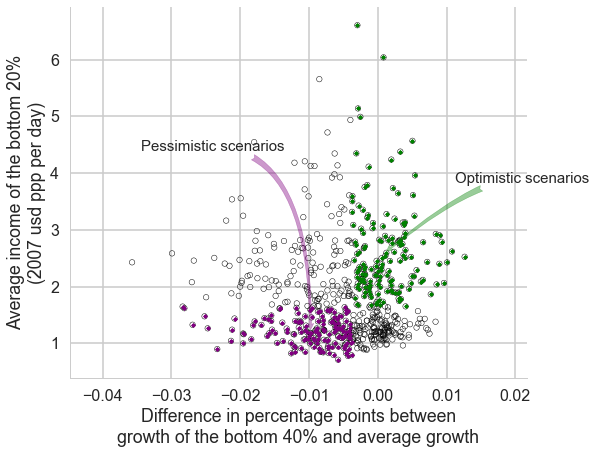

In [28]:
plt.figure(figsize=(18,15))
ax1=plt.subplot(222)
plt.scatter(forprim_bau[data1],forprim_bau[data2],marker='o',facecolors='none', edgecolors='black',s=30)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.margins(0.05)
plt.ylabel("Average income of the bottom 20%\n(2007 usd ppp per day)")
plt.xlabel("Difference in percentage points between\ngrowth of the bottom 40% and average growth")
plotgroup(forprim_bau,data1,data2,opt,"Optimistic scenarios","green",(70,70))
plotgroup(forprim_bau,data1,data2,pess,"Pessimistic scenarios","purple",(-170,180),ang=-90)
#plt.savefig(countrycode+"optandpess.png",bbox_inches="tight",dpi=300)

In [29]:
forprim_bau["opt"]=opt+0
forprim_bau["pess"]=pess+0

# run prim for the optimistic scenario

In [30]:
p = prim.Prim(forprim_bau[experiments_col].reset_index().drop("scenar_id",axis=1),\
              forprim_bau.opt, threshold=0.5, threshold_type=">")

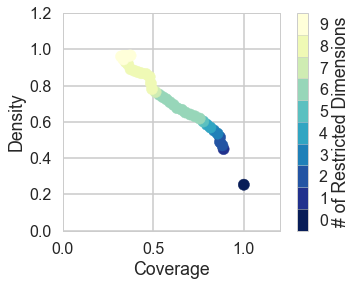

In [31]:
box = p.find_box()
box.show_tradeoff();

In [32]:
box.select(15)
print(box.coverage,box.density)
print(box.limits)

0.631578947368 0.676056338028
                min       max     qp values
isssp5     1.000000  1.000000  3.264404e-12
b          0.048079  0.199867  3.226929e-03
grag       0.002848  0.050101  1.470098e-01
shareemp   0.428467  0.709792  2.761110e-01
sharemanu  0.107762  0.295305  3.365851e-01
skillpag   1.007767  4.786396  4.004398e-01


### min and max for each uncertain variable (for comparison)

In [33]:
forprim_bau[experiments_col].describe().loc[['min','max'],:]

,shareag,sharemanu,shareemp,grserv,grag,grmanu,skillpserv,skillpag,skillpmanu,p,b,isssp5
min,0.107179,0.107762,0.389030,-0.009625,-0.009756,-0.009650,1.007377,1.007767,1.005977,0.001581,0.001431,0.0
max,0.386824,0.304823,0.725359,0.050073,0.050101,0.050102,4.988608,4.997463,4.989220,0.199411,0.199867,1.0


# run prim for the pessimistic scenario

In [40]:
p2 = prim.Prim(forprim_bau[experiments_col].reset_index().drop("scenar_id",axis=1),\
              forprim_bau.pess, threshold=0.5, threshold_type=">")

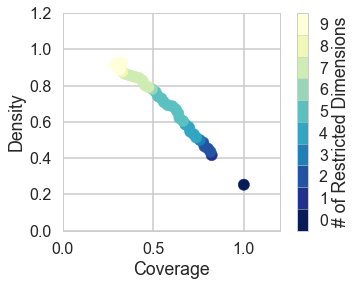

In [41]:
box2 = p2.find_box()
box2.show_tradeoff();

In [42]:
box2.select(15)
print(box2.coverage,box2.density)
print(box2.limits)

0.625 0.669014084507
                 min       max     qp values
isssp5      0.000000  0.000000  7.576367e-09
grag       -0.009756  0.030175  1.038726e-04
b           0.001431  0.162197  2.289067e-03
shareag     0.120384  0.386824  3.615873e-01
skillpmanu  1.005977  4.826479  4.035427e-01


# run the clustering

In [43]:
oois = [data1,data2]

data = np.array([[forprim_bau[oois[0]][0],forprim_bau[oois[1]][0]]])
for i in range(1,len(forprim_bau.index)):
    data = np.concatenate((data,np.array([[forprim_bau[oois[0]][i],forprim_bau[oois[1]][i]]])))

data_norm = normalize(data)

In [44]:
n_clusters = 4
f_value = 0.5
seuil = 1.2

In [45]:
inputs = forprim_bau[experiments_col].reset_index().drop("scenar_id",axis=1)

In [46]:
while n_clusters>2:

    condition = True

    for i in get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs,data_norm)[0]:
        if i.coverage+i.density < seuil:
            condition = False
        else:
            condition = condition&True
    if condition == True:
        break
    else:
        n_clusters = n_clusters - 1
        continue


#Plot of clusters


dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs,data_norm)
boxes = dummy[0]
df = dummy[1]

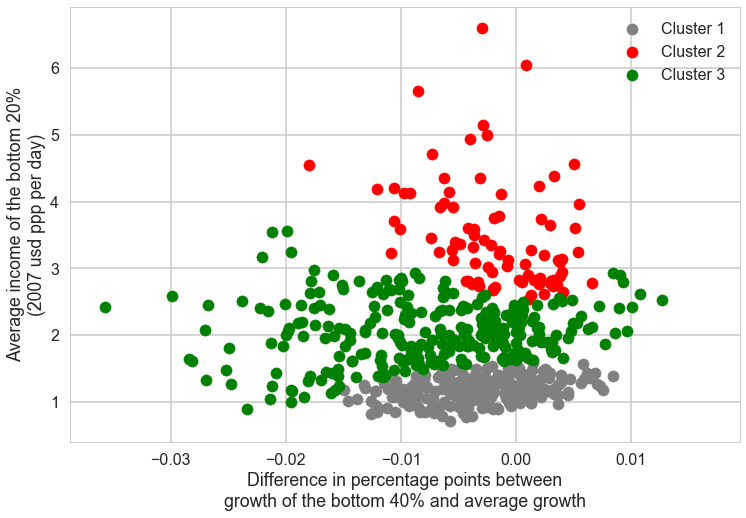

In [47]:
plt.figure(figsize=(12,8))

mycolors = ["grey","red","green","blue"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf[data1],subdf[data2],label="Cluster {}".format(i),c=mycolors[i-1])
plt.legend()
plt.ylabel("Average income of the bottom 20%\n(2007 usd ppp per day)")
plt.xlabel("Difference in percentage points between\ngrowth of the bottom 40% and average growth")

## show prim results for the clusters

### min and max for each uncertain variable (for comparison)

In [48]:
forprim_bau[experiments_col].describe().loc[['min','max'],:]

,shareag,sharemanu,shareemp,grserv,grag,grmanu,skillpserv,skillpag,skillpmanu,p,b,isssp5
min,0.107179,0.107762,0.389030,-0.009625,-0.009756,-0.009650,1.007377,1.007767,1.005977,0.001581,0.001431,0.0
max,0.386824,0.304823,0.725359,0.050073,0.050101,0.050102,4.988608,4.997463,4.989220,0.199411,0.199867,1.0


### (cluster 1)

In [49]:
boxes[0].limits

,min,max,qp values
isssp5,0.000000,0.000000,2.496687e-43
skillpserv,1.007377,4.787361,2.504647e-01
grserv,-0.009625,0.046804,2.584124e-01
shareemp,0.389030,0.709792,2.584124e-01
shareag,0.121114,0.386824,2.584124e-01


### (cluster 2)

In [50]:
boxes[1].limits

,min,max,qp values
isssp5,1.000000,1.000000,4.813089e-11
b,0.039456,0.199867,6.464262e-03
grag,0.007955,0.050101,5.281129e-02
skillpserv,1.729605,4.988608,7.680415e-02
shareemp,0.434995,0.725359,1.379096e-01
shareag,0.107179,0.330971,1.931022e-01
p,0.024678,0.199411,2.434342e-01
sharemanu,0.107762,0.294044,3.676334e-01
grmanu,-0.005805,0.050102,3.949404e-01


### (cluster 3)

In [51]:
boxes[2].limits

,min,max,qp values
isssp5,1.000000,1.000000,1.790789e-21
shareag,0.121114,0.386824,2.303050e-01
grserv,-0.009625,0.046954,2.829000e-01
